In [1]:
### 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchinfo import summary

In [2]:
### 이미지 데이터 준비
filename = '../data/img/orange.png'

In [3]:
# Color 이미지
imgNP = cv2.imread(filename=filename) / 255
print(imgNP.shape, imgNP.ndim)

imgNP2 = cv2.resize(imgNP, (50, 50))
print(imgNP2.shape, imgNP2.ndim)

# Gray 이미지
grayNP = cv2.imread(filename=filename, flags=cv2.IMREAD_GRAYSCALE) / 255
print(grayNP.shape, grayNP.ndim)

grayNP2 = cv2.resize(grayNP, (50, 50))
print(grayNP2.shape, grayNP2.ndim)

(600, 600, 3) 3
(50, 50, 3) 3
(600, 600) 2
(50, 50) 2


In [4]:
### numpy -> FloatTensor 변환
colorTS = torch.FloatTensor(imgNP2)
grayTS = torch.FloatTensor(grayNP2)

In [5]:
print(f'[colorTS] shape : {colorTS.shape}, ndim : {colorTS.ndim}D')
print(f'[grayTS]  shape : {grayTS.shape}, ndim : {grayTS.ndim}D')

[colorTS] shape : torch.Size([50, 50, 3]), ndim : 3D
[grayTS]  shape : torch.Size([50, 50]), ndim : 2D


In [6]:
### cv2.imread 이미지 데이터 형식 : (H, W, C)
### PyTorch    이미지 데이터 형식 : (C, H, W)
### (H, W, C) -> (C, H, W)
colorTS = colorTS.permute(2, 0, 1)
grayTS.unsqueeze_(dim=0)    # C 추가

print(f'[colorTS] shape : {colorTS.shape}, ndim : {colorTS.ndim}D')
print(f'[grayTS]  shape : {grayTS.shape}, ndim : {grayTS.ndim}D')

[colorTS] shape : torch.Size([3, 50, 50]), ndim : 3D
[grayTS]  shape : torch.Size([1, 50, 50]), ndim : 3D


### CNN Layer 살펴보기

In [7]:
### 이미지 데이터로 Conv2D
### [1] 흑백 이미지
conLayer = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=0)         # 입출력 shape 다름
conLayer2 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3, stride=1, padding='same')   # 입출력 shape 동일
conLayer

Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))

In [8]:
output = conLayer(grayTS)
output2 = conLayer2(output)

print(f'[output {output.shape}, [output2] {output2.shape}')

[output torch.Size([5, 48, 48]), [output2] torch.Size([3, 48, 48])


In [9]:
output.shape, output.ndim

(torch.Size([5, 48, 48]), 3)

In [10]:
### Pooling Layer : Conv 층에서 추출한 특징을 다운샘플링
### 결과 shape : C(채널)는 그대로. H, W 줄어듦
pool1 = nn.MaxPool2d(kernel_size=3)             # 안 겹치게 감 (stride = kernel_size)
pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

In [11]:
### conv?D + AF(F.relu())
relu1 = F.relu(input=output)
print(relu1.shape)

output2 = conLayer2(relu1)
relu2 = F.relu(input=output2)
print(relu2.shape)

torch.Size([5, 48, 48])
torch.Size([3, 48, 48])


In [12]:
### 2번째 Conv2D + AF 결과인 피처맵을 Pooling층에 전달
fm1 = pool1(relu2)
print(fm1.shape)

torch.Size([3, 16, 16])


In [13]:
fm2 = pool2(relu2)
print(fm2.shape)

torch.Size([3, 23, 23])


### 추출된 Feature Map 확인

In [15]:
### Conv2D + Conv2D + Pooling
output1 = conLayer(grayTS)
relu1 = F.relu(output1)
print(f'[grayTS] : {grayTS.shape}')
print(f'[relu1] : {relu1.shape}')

output2 = conLayer2(relu1)
relu2 = F.relu(output2)
print(f'[relu2] : {relu2.shape}')

mp1 = pool1(relu2)

print(f'[mp1] {mp1.shape}')

[grayTS] : torch.Size([1, 50, 50])
[relu1] : torch.Size([5, 48, 48])
[relu2] : torch.Size([3, 48, 48])
[mp1] torch.Size([3, 16, 16])


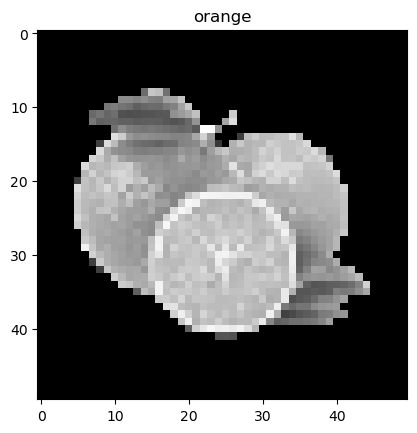

In [17]:
### 시각화
import matplotlib.pyplot as plt

grayImg = grayTS.squeeze()

plt.title('orange')
plt.imshow(grayImg, cmap='gray')
plt.show()

torch.Size([48, 48])
torch.Size([48, 48])
torch.Size([48, 48])
torch.Size([48, 48])
torch.Size([48, 48])
Conv2D Layer


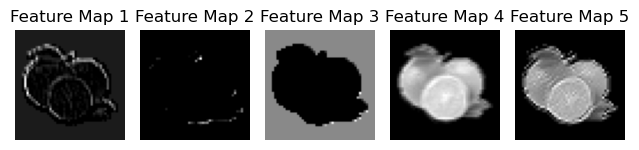

In [49]:
### 첫번째 Conv2D Layer 추출 피쳐맵

for idx in range(relu1.shape[0]):
    print(relu1[idx].shape)
    plt.subplot(1, 5, idx+1)
    plt.imshow(X=relu1[idx].detach().numpy(), cmap='gray')
    plt.title(label=f'Feature Map {idx+1}')
    plt.axis('off')     # 축 눈금표시 삭제
print('Conv2D Layer')
# plt.suptitle('Conv2D Layer')
plt.tight_layout()
plt.show()

In [50]:
def print_featuremap(fm_tensor, cols, layer_name):
    print(f'[{layer_name} Layer]')
    for idx in range(fm_tensor.shape[0]):
        plt.subplot(1, cols, idx+1)
        plt.imshow(X=fm_tensor[idx].detach().numpy(), cmap='gray')
        plt.title(label=f'Feature Map {idx+1}')
        plt.axis('off')     # 축 눈금표시 삭제
    plt.tight_layout()
    plt.show()

[First Layer]


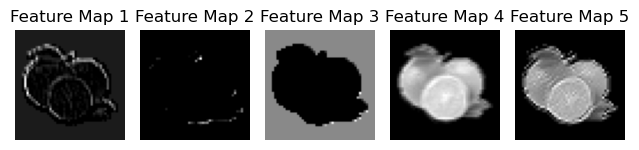

In [51]:
print_featuremap(relu1, 5, 'First')

[Second Layer]


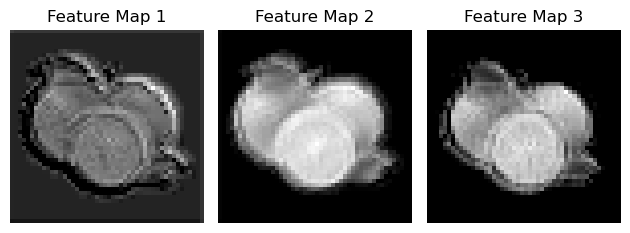

In [52]:
print_featuremap(relu2, 3, 'Second')

[Third Layer]


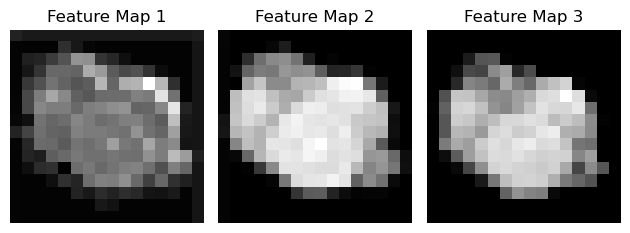

In [53]:
print_featuremap(mp1, 3, 'Third')